# Timeseries project

# Imports

In [2]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 MB 18.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 32.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split

# Simulate data

Kasper's simulated data

In [4]:
def timeseries_function(N, num_trajectories):
    data = []
    for n in range(num_trajectories):
        
        dt = 1/N
        sqrt_dt = np.sqrt(dt)
        x = np.linspace(0,1,N)
        y = np.zeros(N)
        koeff_1 = 12+np.random.normal(0,0.1)
        koeff_3 = -4*(35+np.random.normal(0,0.1))
        koeff_5 = -4+np.random.normal(0,0.1)
        koeff_7 = -2+np.random.normal(0,0.1)
        for i in range(1,N):
            y[i] = np.maximum(y[i-1] + 
                              (koeff_7*(x[i]-(0.5+np.random.normal(0,0.2)))**7 + koeff_5*(x[i]-(0.5+np.random.normal(0,0.2)))**5
                               + koeff_3*(x[i]-(0.5+np.random.normal(0,0.02)))**(3) + koeff_1*(x[i]-(0.5+np.random.normal(0,0.05))))*dt \
                              +sqrt_dt*np.random.normal(0,0.005),0)
        data.append(y)
    data = np.array(data, dtype=np.float32)
    return x,data

In [5]:
num_trajectories = 1000
sequence_length = 100

x, data = timeseries_function(sequence_length, num_trajectories)

data_torch = torch.tensor(data)
dataset = TensorDataset(data_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print('Done')

Done


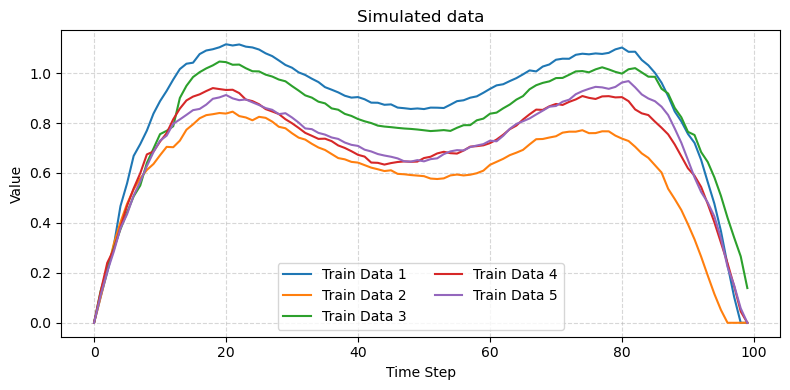

In [6]:
plt.figure(figsize=(8, 4))
for i in range(5):  # plot three trajectories
    plt.plot(data[i], label=f'Train Data {i+1}', linestyle='-')

# Adding titles and labels for better readability
plt.title("Simulated data")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend(loc='lower center', ncol=2)  # Place legend on the upper left

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Train the autoencoder

Define the autoencoder

In [7]:
# Define the Autoencoder Model
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Train the autoencoder

In [8]:
# Model parameters
input_dim = sequence_length
encoding_dim = 16  # Dimension of the encoded representation
model = TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)

In [9]:
# Train the Autoencoder
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # MSE between output and input
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Print average loss
    if epoch % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

Epoch [1/100], Loss: 0.4645


# Evaluation

In [10]:
# Evaluate the Autoencoder on Some Data
# Testing the model on a few samples to see reconstruction
_, test_data = timeseries_function(sequence_length, 5)
test_data_torch = torch.tensor(test_data)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    reconstructed = model(test_data_torch)


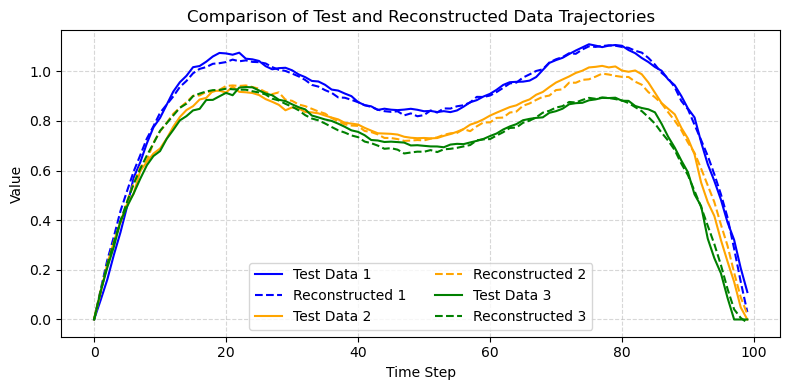

In [11]:
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(8, 4))
for i in range(3):  # plot three trajectories
    plt.plot(test_data[i], label=f'Test Data {i+1}', linestyle='-', color= colors[i])
    plt.plot(reconstructed[i], label=f'Reconstructed {i+1}', linestyle='--', color=colors[i])

# Adding titles and labels
plt.title("Comparison of Test and Reconstructed Data Trajectories")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend(loc='lower center', ncol=2)

plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid
plt.tight_layout()
plt.show()


# Apply the encoder

Define the encoder model

In [12]:
# Extract Encoder
# We'll use only the encoder part of the autoencoder model
class Encoder(nn.Module):
    def __init__(self, original_autoencoder):
        super(Encoder, self).__init__()
        # Copy encoder layers from the trained autoencoder
        self.encoder = original_autoencoder.encoder

    def forward(self, x):
        return self.encoder(x)

Apply the encoder to the trained data

In [13]:
# Initialize encoder with the trained autoencoder's encoder part
encoder = Encoder(model)

# Generate Latent Representations
# Set the encoder to evaluation mode
encoder.eval()

# Pass the training data through the encoder to get the latent representations
with torch.no_grad():
    latent_representations = encoder(data_torch).numpy()  # Shape: (num_samples, encoding_dim)


Visualise

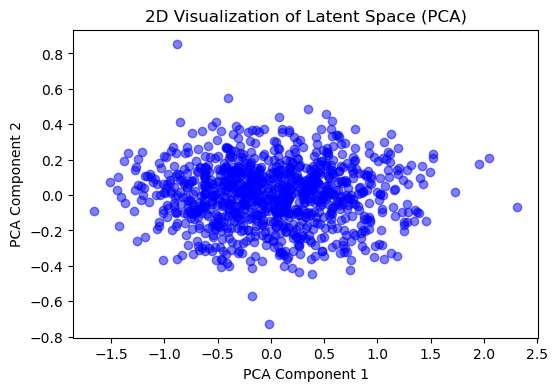

In [14]:
# Apply PCA to Reduce to 2D
# We use PCA to reduce the latent representations to 2D for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)  # Shape: (num_samples, 2)

# Plot the 2D Latent Space
plt.figure(figsize=(6, 4))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.5)
plt.title("2D Visualization of Latent Space (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

Apply other data to autoencoder

Generate sine data

In [15]:
# Generate Synthetic Time Series Data
def generate_time_series_data(num_samples=1000, sequence_length=50):
    """
    Generates a sinusoidal time series dataset with noise.
    Returns a tensor of shape (num_samples, sequence_length).
    """
    x = np.linspace(0, 4 * np.pi, sequence_length)  # Base time series
    data = []
    for _ in range(num_samples):
        noise = np.random.normal(0, 0.1, sequence_length)  # Add noise
        sample = np.sin(x) + noise  # Sinusoidal with noise
        data.append(sample)
    data = np.array(data, dtype=np.float32)
    return torch.tensor(data)


Input zero vector or mean vector as template

In [16]:
data_zeroes = np.zeros(shape=(50,sequence_length),dtype=np.float32)
data_zeroes = torch.tensor(data_zeroes)

data_mean = data.mean(axis=0)
data_mean = torch.tensor(data_mean)

# Generate data
data_sine = generate_time_series_data(num_samples=50, sequence_length=sequence_length)

In [17]:
# Generate Latent Representations
# Set the encoder to evaluation mode
encoder.eval()

# Pass the training data through the encoder to get the latent representations
with torch.no_grad():
    latent_representations_zeroes = encoder(data_zeroes).numpy()  # Shape: (num_samples, encoding_dim)
    latent_representations_mean = encoder(data_mean).numpy()  # Shape: (num_samples, encoding_dim)
    latent_representations_sine = encoder(data_sine).numpy()  # Shape: (num_samples, encoding_dim)


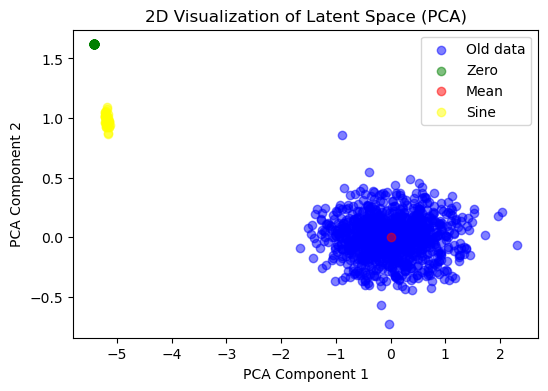

In [18]:
# Apply PCA to Reduce to 2D
# We use PCA to reduce the latent representations to 2D for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)  # Shape: (num_samples, 2)
latent_2d_zeros = pca.transform(latent_representations_zeroes)  # Shape: (num_samples, 2)
latent_2d_sine = pca.transform(latent_representations_sine)  # Shape: (num_samples, 2)
latent_2d_mean = pca.transform(latent_representations_mean.reshape(1, -1))  # Shape: (num_samples, 2)

# Plot the 2D Latent Space
plt.figure(figsize=(6, 4))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.5, label='Old data')
plt.scatter(latent_2d_zeros[:, 0], latent_2d_zeros[:, 1], c='green', alpha=0.5, label='Zero')
plt.scatter(latent_2d_mean[:, 0], latent_2d_mean[:, 1], c='red', alpha=0.5, label='Mean')
plt.scatter(latent_2d_sine[:, 0], latent_2d_sine[:, 1], c='yellow', alpha=0.5, label='Sine')

plt.legend()
plt.title("2D Visualization of Latent Space (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Real data

In [19]:
random_SEED = 42
train_fraction = 0.7
GRF_F_V_PRO_right = pd.read_csv(r'GRF_F_V_PRO_right.csv')
patient_IDs = np.unique(GRF_F_V_PRO_right['SUBJECT_ID'])

# Number of samples in the training data set
train_size = int(len(patient_IDs)*train_fraction)

patient_IDs_train, patient_IDs_test = train_test_split(patient_IDs, train_size = train_size, random_state=random_SEED)

# Create datasets
train_set = GRF_F_V_PRO_right.loc[GRF_F_V_PRO_right['SUBJECT_ID'].isin(patient_IDs_train)]
test_set = GRF_F_V_PRO_right.loc[GRF_F_V_PRO_right['SUBJECT_ID'].isin(patient_IDs_test)]

train_set.index = pd.RangeIndex(len(train_set.index))
test_set.index = pd.RangeIndex(len(test_set.index))

data = np.array(train_set,dtype=np.float32)[:,3:]

data_torch = torch.tensor(data)
dataset = TensorDataset(data_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print('Done')

Done


# Train model

In [22]:
# Model parameters
sequence_length = data.shape[1]
input_dim = sequence_length
encoding_dim = 16  # Dimension of the encoded representation
model = TimeSeriesAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim)

# Train the Autoencoder
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        inputs = batch[0]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)  # MSE between output and input
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Print average loss per epoch
    if epoch % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

Epoch [1/20], Loss: 0.0179


# Evaluation 

In [25]:
# Evaluate the Autoencoder on Some Data
# Testing the model on a few samples to see reconstruction
test_data = np.array(test_set, dtype=np.float32)[:,3:]
test_data_torch = torch.tensor(test_data)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    reconstructed = model(test_data_torch)


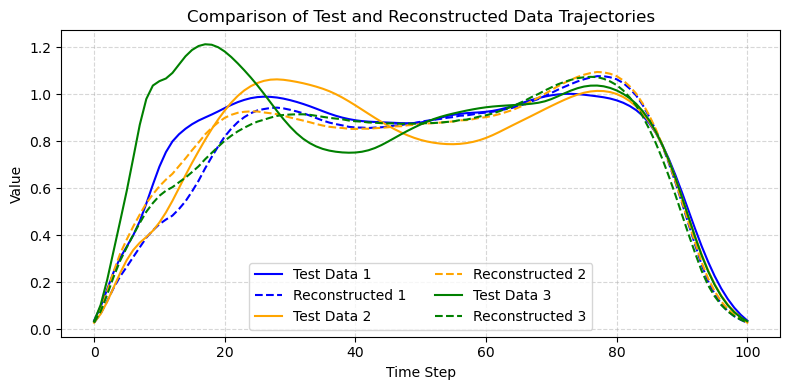

In [ ]:
colors = ['blue', 'orange', 'green']

plt.figure(figsize=(8, 4))
for i,j in enumerate([100,200,300]):  # plot three trajectories
    plt.plot(test_data[j], label=f'Test Data {i+1}', linestyle='-', color= colors[i])
    plt.plot(reconstructed[j], label=f'Reconstructed {i+1}', linestyle='--', color=colors[i])

# Adding titles and labels for better readability
plt.title("Comparison of Test and Reconstructed Data Trajectories")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend(loc='lower center', ncol=2)  # Place legend on the upper left

plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid
plt.tight_layout()  # Adjust layout for better fit
plt.show()


# Apply encoder

In [27]:
# Initialize encoder with the trained autoencoder's encoder part
encoder = Encoder(model)

# Generate Latent Representations
# Set the encoder to evaluation mode
encoder.eval()

data_zeroes = np.zeros(shape=(50,sequence_length),dtype=np.float32)
data_zeroes = torch.tensor(data_zeroes)

# Pass the training data through the encoder to get the latent representations
with torch.no_grad():
    latent_representations = encoder(data_torch).numpy()  # Shape: (num_samples, encoding_dim)
    latent_representations_test = encoder(test_data_torch).numpy()  # Shape: (num_samples, encoding_dim)
    latent_representations_mean = encoder(data_torch.mean(axis=0)).numpy()
    latent_representations_zeroes = encoder(data_zeroes).numpy()  # Shape: (num_samples, encoding_dim)


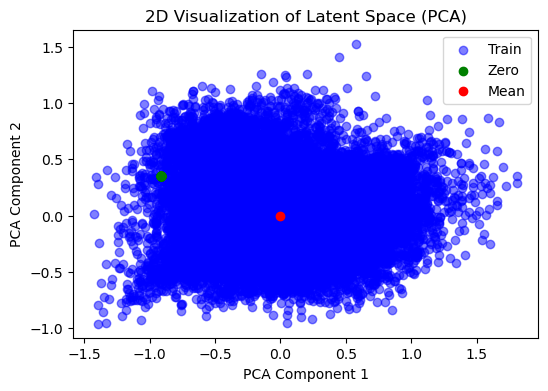

In [28]:
# Apply PCA to Reduce to 2D
# We use PCA to reduce the latent representations to 2D for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_representations)  # Shape: (num_samples, 2)
latent_2d_test = pca.transform(latent_representations_test)  # Shape: (num_samples, 2)
latent_2d_mean = pca.transform(latent_representations_mean.reshape(1, -1))  # Shape: (num_samples, 2)
latent_2d_zeroes = pca.transform(latent_representations_zeroes)  # Shape: (num_samples, 2)

# Plot the 2D Latent Space
plt.figure(figsize=(6, 4))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.5, label='Train')
#plt.scatter(latent_2d_test[:, 0], latent_2d_test[:, 1], c='yellow', alpha=0.5, label='Mean')
plt.scatter(latent_2d_zeroes[:, 0], latent_2d_zeroes[:, 1], c='green', alpha=1, label='Zero')
plt.scatter(latent_2d_mean[:, 0], latent_2d_mean[:, 1], c='red', alpha=1, label='Mean')
plt.legend()
plt.title("2D Visualization of Latent Space (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

Eriks simulated data

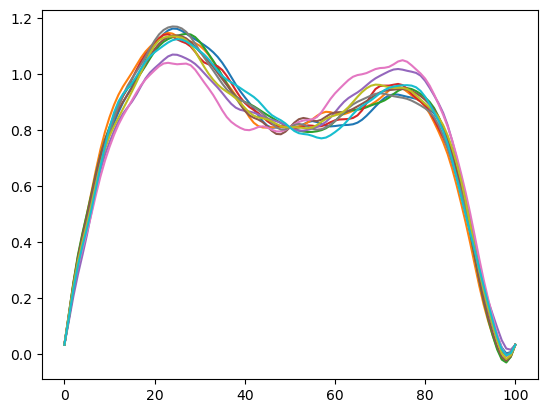

In [29]:
GRF_F_V_PRO_right = pd.read_csv(r'GRF_F_V_PRO_right.csv')
mat = np.array(GRF_F_V_PRO_right)[:,3:]
mean = np.mean(mat, axis=0)

def random_sine_combo(t,N,spec):
    '''N is the number of sine waves to sum, spec is the frequency spectrum'''
    out = 0 
    for i in range(1,N):
        out = out + np.sin(2*np.pi*i*t/100)*spec[i]
    return out

inds = np.arange(101)

#generate a 100 petrubed means 
curves = mean + np.array([random_sine_combo(inds, 20, np.random.rand(30)/(np.arange(2,32)**1.9)) for i in range(10)])

plt.plot(curves.T)